In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from math import sin, cos, asin, sqrt, radians, pi
from scipy.optimize import curve_fit, fsolve
import random
from tabulate import tabulate

matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams.update({'font.size': 20})

In [2]:
#File names
crater=['crater'+f'{i:03}'+'_hpar' for i in range(1,106)]
crater_lon=['crater'+f'{i:03}'+'_hpar'+'.lon' for i in range(1,106)]
crater_lat=['crater'+f'{i:03}'+'_hpar'+'.lat' for i in range(1,106)]
files='/Users/iswi5283/Desktop/research/Craters/'
cfiles='/Users/iswi5283/Desktop/research/Craters/data/hpar/'
sfiles='/Users/iswi5283/Desktop/research/Craters/data/hpar_og/'
rfiles='/Users/iswi5283/Desktop/research/Craters/data/ra/'

centers = pd.read_csv(files+'MoonCraters.csv')
cNames = centers['Names '].values
cNumber = centers['Crater No.'].values
cLon = centers['Lon (°) '].values
cLat = centers['Lat (°) '].values
cD = centers['D (km)'].values #km
cR = cD / 2 #km
ages_maz = centers['Age (Myr)'].values #Myr

In [3]:
def gCD(lon1, lat1, lon2, lat2, R=1737.4):
    
    """Haversine Formula: 
    Calculating distances between two points given their longitudes and latitudes
    R_moon=1737.4 km"""
    
    lon1_rad = radians(lon1) #convert to radians
    lat1_rad = radians(lat1)
    lon2_rad = radians(lon2)
    lat2_rad = radians(lat2)
    
    dlon2 = (lon2_rad - lon1_rad) / 2 # difference in longitude
    dlat2 = (lat2_rad - lat1_rad) / 2 # difference in latitude
    
    sin2_dlon2 = (sin(dlon2))**2 # sin squared of difference in longitude
    sin2_dlat2 = (sin(dlat2))**2 # sin squared of difference in latitude
    
    d = 2 * R * asin ( sqrt( sin2_dlat2 + cos(lat1_rad) * cos(lat2_rad) * sin2_dlon2 ) )
    
    return d

In [4]:
#Load each individual crater's H-parameter DIVINER data
hpar=[np.genfromtxt(sfiles+crater[i])*(np.genfromtxt(sfiles+crater[i])!=-32768) for i in range(105)]
#Load each individual crater's longitude and latitude grids
lon_hpar=[np.genfromtxt(sfiles+crater_lon[i]) for i in range(105)]
lat_hpar=[np.genfromtxt(sfiles+crater_lat[i]) for i in range(105)]

In [5]:
#Shape of each crater file
hpar_m = [hpar[i].shape[0] for i in range(105)]
hpar_n = [hpar[i].shape[1] for i in range(105)]

In [6]:
#Create grid in terms of distance from the crater centers (in km)
distances_hpar=[np.array([[gCD(cLon[i],cLat[i],lon_hpar[i][j,k],lat_hpar[i][j,k]) for k in range(hpar_n[i])] for j in range(hpar_m[i])]) for i in range(105)]
#Distance grid in terms of crater radii from the crater centers
distances_hpar_cr=[np.array((distances_hpar[i]/cR[i])-1) for i in range(105)]

In [7]:
#Define the regions of interest surrounding the craters
#Model 1: from -0.1 to 0.8 crater radii
#Model 2: from -0.2 to 0.8 crater radii
cond_hpar_1=[np.array([[(dist>=-0.1)&(dist<=0.8) for dist in row] for row in distances_hpar_cr[i]]) for i in range(105)]
cond_hpar_2=[np.array([[(dist>=-0.2)&(dist<=0.8) for dist in row] for row in distances_hpar_cr[i]]) for i in range(105)]

In [8]:
#All H-parameter values within the regions of Model 1 and 2
h_par_values_1=[]
h_par_values_err_1=[]
h_par_values_2=[]
h_par_values_err_2=[]
for i in range(105):
    h_1=[]
    h_2=[]
    for j in np.arange(0,hpar_m[i]):
        for k in np.arange(0,hpar_n[i]):
            if (cond_hpar_1[i][j,k]==True)&(hpar[i][j,k]>0):
                h_1.append(hpar[i][j,k])
            if (cond_hpar_2[i][j,k]==True)&(hpar[i][j,k]>0):
                h_2.append(hpar[i][j,k])
    h_par_values_1.append(h_1)
    h_par_values_err_1.append(np.std(h_1))
    h_par_values_2.append(h_2)
    h_par_values_err_2.append(np.std(h_2))

In [9]:
#Final H-parameter values assigned to each crater
#Model 1: 10th percentile
#Model 2: 15th percentile
h_par_1=np.array([np.percentile(h_par_values_1[i],10) for i in range(105)])
h_par_err_1=np.array([np.std(hpar[i],where=cond_hpar_1[i])/np.sqrt(len(cond_hpar_1[i])/cR[i]) for i in range(105)])

h_par_2=np.array([np.percentile(h_par_values_2[i],15) for i in range(105)])
h_par_err_2=np.array([np.std(hpar[i],where=cond_hpar_2[i])/np.sqrt(len(cond_hpar_2[i])/cR[i]) for i in range(105)])

In [10]:
def func_age(x, A, B, C, tau):
    """H-parameter function given age (x)"""
    return A*np.exp(-x/tau)+B*(1-np.exp(-x/tau))+C*np.log10(x)

In [11]:
#Define parameters of the model fit between H-parameter and ages
new_popt_1,new_pcov_1=curve_fit(func_age,ages_maz,h_par_1,sigma=h_par_err_1,p0=(0.015,0.06,0.02,350),bounds=(0.001,np.inf))
new_popt_2,new_pcov_2=curve_fit(func_age,ages_maz,h_par_2,sigma=h_par_err_2,p0=(0.032,0.05,0.02,150),bounds=(0.001,np.inf))

new_err_1=np.sqrt(np.diag(new_pcov_1))
new_err_2=np.sqrt(np.diag(new_pcov_2))

(nA1,nB1,nC1,ntau1)=new_popt_1
(nA1_err,nB1_err,nC1_err,ntau1_err)=new_err_1
(nA2,nB2,nC2,ntau2)=new_popt_2
(nA2_err,nB2_err,nC2_err,ntau2_err)=new_err_2

In [12]:
def equation1(x,H):
    '''Equation used to calculate ages from Model 1 of the H-parameter age estimates'''
    return nA1*np.exp(-x/ntau1)+nB1*(1-np.exp(-x/ntau1))+nC1*np.log10(x)-H

def equation2(x,H):
    '''Equation used to calculate ages from Model 2 of the H-parameter age estimates'''
    return nA2*np.exp(-x/ntau2)+nB2*(1-np.exp(-x/ntau2))+nC2*np.log10(x)-H

def age_error1(x, H, H_error):
    '''Errors for the calculate ages from Model 1 of the H-parameter age estimates'''
    df_dA = np.exp(-x/ntau1)
    df_dB = 1 - np.exp(-x/ntau1)
    df_dC = np.log(x)
    df_dtau = (nA1*x*np.exp(-x/ntau1) - nB1*x*np.exp(-x/ntau1) + nC1*x**2) / ntau1**2
    t_error = np.sqrt((H_error**2 + (nA1_err * df_dA)**2 + (nB1_err * df_dB)**2 + (nC1_err * df_dC)**2 + (ntau1_err * df_dtau)**2))
    return t_error

def age_error2(x, H, H_error):
    '''Errors for the calculate ages from Model 2 of the H-parameter age estimates'''
    df_dA = np.exp(-x/ntau2)
    df_dB = 1 - np.exp(-x/ntau2)
    df_dC = np.log(x)
    df_dtau = (nA2*x*np.exp(-x/ntau2) - nB2*x*np.exp(-x/ntau2) + nC2*x**2) / ntau2**2
    t_error = np.sqrt((H_error**2 + (nA2_err * df_dA)**2 + (nB2_err * df_dB)**2 + (nC2_err * df_dC)**2 + (ntau2_err * df_dtau)**2))
    return t_error

t_values_1 = np.zeros(105)
t_values_2 = np.zeros(105)
t_values_1_err = np.zeros(105)
t_values_2_err = np.zeros(105)

table_ages=[]

#Calculating ages based on H-parameter values for each crater
for i in range(105):
    #Ages from 4-1350 Myr (youngest and oldest ages in Mazroeui Ages) 
    initial_guesses = [ages_maz[i],4,100,200,300,400,500,600,700,800,900,1000,1350]
    found_solution = False

    for guess in initial_guesses:
        try:
            t_solution1 = fsolve(equation1, x0=guess, args=h_par_1[i])
            age_error_1 = age_error1(t_solution1[0], h_par_1[i],h_par_err_1[i])
            t_solution2 = fsolve(equation2, x0=guess, args=h_par_2[i])
            age_error_2 = age_error2(t_solution2[0], h_par_2[i],h_par_err_1[i])
            
            #If the ages are exactly the guess or Mazroeui Ages, the crater age is either much 
            #higher or lower than the inital guess
            if (t_solution1[0] != (ages_maz[i] or guess))&(t_solution2[0] != (ages_maz[i] or guess)):
                #Scale the error if needed. Some age uncertainities are too small
                if (h_par_1[i]/h_par_err_1[i])>= (t_solution1[0]/age_error_1):
                    t_values_1[i]=t_solution1[0]
                    t_values_2[i]=t_solution2[0]
                    t_values_1_err[i]=age_error_1
                    t_values_2_err[i]=age_error_2
                    found_solution = True
                    break  
                else:
                    age_error_scale=(t_solution1[0]/age_error_1)/(h_par_1[i]/h_par_err_1[i])
                    t_values_1[i]=t_solution1[0]
                    t_values_2[i]=t_solution2[0]
                    t_values_1_err[i]=age_error_1*age_error_scale
                    t_values_2_err[i]=age_error_2*age_error_scale
                    found_solution = True
                    break
        except Exception:
            pass
        
    if not found_solution:
        print(f"Could not find a solution for {cNames[i]}")

/var/folders/lq/x5h8nj3j0tv1vb0dfg7387f800_w_3/T/ipykernel_99263/2703617606.py:3: RuntimeWarning: invalid value encountered in log10
  return nA1*np.exp(-x/ntau1)+nB1*(1-np.exp(-x/ntau1))+nC1*np.log10(x)-H
/Users/iswi5283/anaconda3/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/var/folders/lq/x5h8nj3j0tv1vb0dfg7387f800_w_3/T/ipykernel_99263/2703617606.py:7: RuntimeWarning: invalid value encountered in log10
  return nA2*np.exp(-x/ntau2)+nB2*(1-np.exp(-x/ntau2))+nC2*np.log10(x)-H


In [13]:
#File Names for craters surrounding apollo17 site
afiles='/Users/iswi5283/Desktop/research/Craters/data/apollo17/'

a_centers = pd.read_csv(files+'Apollo17Coord.csv')
aNames = a_centers['Names '].values
aNumber = a_centers['Crater No.'].values
aLon = a_centers['Lon (°) '].values
aLat = a_centers['Lat (°) '].values
aD = a_centers['D (km)'].values
aR = aD / 2 #km
apolloo=['apollo'+f'{i:02}'+'_hpar' for i in range(1,12)]
apolloo_lon=['apollo'+f'{i:02}'+'_hpar'+'.lon' for i in range(1,12)]
apolloo_lat=['apollo'+f'{i:02}'+'_hpar'+'.lat' for i in range(1,12)]

In [14]:
#Load each individual apollo crater's H-parameter DIVINER data
apollo=[np.genfromtxt(afiles+apolloo[i])*(np.genfromtxt(afiles+apolloo[i])!=-32768) for i in range(11)]
#Load each individual apollo crater's longitude and latitude grids
apollo_lon=[np.genfromtxt(afiles+apolloo_lon[i]) for i in range(11)]
apollo_lat=[np.genfromtxt(afiles+apolloo_lat[i]) for i in range(11)]

In [15]:
#Shape of each apollo crater file
a_m = [apollo[i].shape[0] for i in range(11)]
a_n = [apollo[i].shape[1] for i in range(11)]

In [16]:
#Create grid in terms of distance from the crater centers (in km)
a_distances=[np.array([[gCD(aLon[i],aLat[i],apollo_lon[i][j,k],apollo_lat[i][j,k]) for k in range(a_n[i])] for j in range(a_m[i])]) for i in range(11)]
#Distance grid in terms of crater radii from the crater centers
a_distances_cr=[np.array((a_distances[i]/aR[i])-1) for i in range(11)]

In [17]:
#Define the regions of interest surrounding the craters
#Model 1: from -0.1 to 0.8 crater radii
#Model 2: from -0.2 to 0.8 crater radii
a_cond_hpar_1=[np.array([[(dist>=-0.1)&(dist<=0.8) for dist in row] for row in a_distances_cr[i]]) for i in range(11)]
a_cond_hpar_2=[np.array([[(dist>=-0.2)&(dist<=0.8) for dist in row] for row in a_distances_cr[i]]) for i in range(11)]

In [18]:
#All H-parameter values within the regions of Model 1 and 2
a_h_par_values_1=[]
a_h_par_values_err_1=[]
a_h_par_values_2=[]
a_h_par_values_err_2=[]
for i in range(11):
    a_h_1=[]
    a_h_2=[]
    for j in np.arange(0, a_m[i]):
        for k in np.arange(0, a_n[i]):
            if (a_cond_hpar_1[i][j,k]==True)&(apollo[i][j,k]>0):
                a_h_1.append(apollo[i][j,k])
            if (a_cond_hpar_2[i][j,k]==True)&(apollo[i][j,k]>0):
                a_h_2.append(apollo[i][j,k])
    a_h_par_values_1.append(a_h_1)
    a_h_par_values_err_1.append(np.std(a_h_1))
    a_h_par_values_2.append(a_h_2)
    a_h_par_values_err_2.append(np.std(a_h_2))

In [19]:
#Final H-parameter values assigned to each crater
#Model 1: 10th percentile
#Model 2: 15th percentile
a_h_par_1=np.array([np.percentile(a_h_par_values_1[i],10) for i in range(11)])
a_h_par_err_1=np.array([np.std(apollo[i],where=a_cond_hpar_1[i])/np.sqrt(len(a_cond_hpar_1[i])/aR[i]) for i in range(11)])

a_h_par_2=np.array([np.percentile(a_h_par_values_2[i],15) for i in range(11)])
a_h_par_err_2=np.array([np.std(apollo[i],where=a_cond_hpar_2[i])/np.sqrt(len(a_cond_hpar_2[i])/aR[i]) for i in range(11)])

a_h_par_1

array([0.0455185, 0.0475986, 0.0497973, 0.048607 , 0.0300991, 0.0432775,
       0.0480028, 0.051742 , 0.038164 , 0.0567305, 0.044729 ])

In [20]:
testa = np.exp(-a_h_par_1[0]/ntau1)
testb = 1 - np.exp(-a_h_par_1[0]/ntau1)
testc = np.log(a_h_par_1[0])
testt = (nA1*a_h_par_1[0]*np.exp(-a_h_par_1[0]/ntau1) - nB1*a_h_par_1[0]*np.exp(-a_h_par_1[0]/ntau1) + nC1*a_h_par_1[0]**2) / ntau1**2
test_t_error = np.sqrt((a_h_par_err_1[0]**2 + (nA1_err * testa)**2 + (nB1_err * testb)**2 + (nC1_err * testc)**2 + (ntau1_err * testt)**2))
print(testa)
print(testb)
print(testc)
print(testt)
print(test_t_error)

0.9995992274834473
0.0004007725165526832
-3.089636442255339
-1.1158853311115834e-07
0.019327760161088135


In [21]:
a_cont_ages_1 = np.zeros(11)
a_cont_ages_err_1 = np.zeros(11)
a_cont_ages_2 = np.zeros(11)
a_cont_ages_err_2 = np.zeros(11)

#Calculating ages based on H-parameter values for each crater
for i in range(11):
    initial_guesses = np.linspace(10,4000,100)
    found_solution = False

    for guess in initial_guesses:
        try:
            t_solution1 = fsolve(equation1, x0=guess, args=a_h_par_1[i])
            t_solution2 = fsolve(equation2, x0=guess, args=a_h_par_2[i])
            age_error_1 = age_error1(t_solution1[0], a_h_par_1[i], a_h_par_err_1[i])
            age_error_2 = age_error2(t_solution2[0], a_h_par_2[i], a_h_par_err_2[i])
            
            if (t_solution1[0] != guess)&(t_solution2[0] != guess):
                if (a_h_par_1[i]/a_h_par_err_1[i])>= (t_solution1[0]/age_error_1):
                    a_cont_ages_1[i]=t_solution1[0]
                    a_cont_ages_err_1[i]=age_error_1
                    a_cont_ages_2[i]=t_solution2[0]
                    a_cont_ages_err_2[i]=age_error_2
                    found_solution = True
                    break  
                else:
                    a_age_error_scale=(t_solution1[0]/age_error_1)/(a_h_par_1[i]/a_h_par_err_1[i])
                    a_cont_ages_1[i]=t_solution1[0]
                    a_cont_ages_err_1[i]=age_error_1*a_age_error_scale
                    a_cont_ages_2[i]=t_solution2[0]
                    a_cont_ages_err_2[i]=age_error_2*a_age_error_scale
                    found_solution = True
                    break
        except Exception:
            pass

    if not found_solution:
        print(f"Could not find a solution for {aNames[i]}")

In [22]:
def ejectaThickness(D, r, beta=0.1, B=3):
    '''Ejecta thickness at given distance from the center of a crater.
    Assumes power-law decay of thickness vs. distance,
    h(r) = h(D/2)*(2r/D)**-B
    with the crater excavation volume that of a spherical cap.
    [cf. Melosh (1989), Impact Cratering: A Geologic Process, p. 90]'''
    R = D/2 # Crater radius (meters)
    h0 = (2/3) * R *(B-2)*beta*(3/4 - beta**2) # h(r/R), i.e. at rim
    h = np.array(h0 * (r/R)**-B) # distance in meters
    h[np.abs(r)<R] = 0 # thickness inside crater is zero
    return h #meters

In [23]:
#Colors of all craters 
colorlist={'Nicolai A': '#5dd716', 'No name 39': '#707730','Thales': '#cbca85', 'Mosting A': '#9650f1',
            'Innes G': '#6e5b54','Ryder': '#a0314f','No name 18': '#0f30f4','Mercurius H': '#4df8e7',
            'No name 31': '#b2070d','Lagrange H': '#15fd00','Lalande': '#44fec0','No name 21': '#673a9b',
            'Aratus': '#384748','No name 1': '#f3d044','No name 9': '#5851ab','Egede A': '#c3a095',
            'No name 30': '#2f540f','Moore F': '#48c281','Lagrange D': '#949adb','No name 3': '#4e590b',
            'Sundman V': '#d98ab6','Aitken A': '#38397f','Papaleksi Q': '#4750f3','Pythagoras K': '#097de4',
            'No name 19': '#04f31b','Messier A': '#b6f838','Carrel': '#746e2f','No name 5': '#89e0ed',
            'Crookes': '#0a6969','Kepler': '#4966df','Alfraganus C': '#2dd992','Fechner T': '#9429cf',
            'Hume Z': '#1bf374',"O'Day M": '#0219d4','Jackson': '#21f577','Geminus C': '#c2dd1a',
            'Das': '#e13a98','Reimarus H': '#bc4549','No name 23': '#59b4e5','No name 34': '#e88d7d',
            'Petavius B': '#f5a8ab','No name 17': '#7b9681','Tharp': '#cc9a69','No name 20': '#324daa',
            'No name 27': '#d8eb19','No name 16': '#773a87','No name 14': '#1347d1','Aristarchus': '#44ce53',
            'Glushko': '#11ba03','Ohm': '#b81a01','Avery': '#89a32b','Eichstadt G': '#9410d5',
            'Janssen K': '#295305','Copernicus': '#563569','No name 35': '#59120a','No name 33': '#6cef7d',
            'No name 6': '#235310','No name 22': '#7b1d04','Byrgius A': '#42d755','No name 11': '#065e3e',
            'No name 36': '#f2e41b','Necho': '#c07df2','Hilbert A': '#51d42a','Bessarion': '#6afd2b',
            'Fraunhofer G': '#83a3c8','Goddard A': '#d2641f','No name 2': '#810122','No name 38': '#82453f',
            'Schwabe F': '#f0a6f8','No name 32': '#e64d04','Beaumont D': '#4ba562','Rayet Y': '#612ab6',
            'Furnerius A': '#4c1641','No name 12': '#c96f56','Cameron': '#0c9e10','Mohorovicic F': '#f6347a',
            'Gambart A': '#7125e9','Gauss J': '#22d4be','No name 28': '#ce25ef','No name 4': '#1302c8',
            'No name 7': '#740e3a','Dawes': '#8a26e7','Democritus A': '#be8346','Dionysius': '#ce3283',
            'Euclides C': '#6069f2','Sirsalis F': '#3c07f7','No name 10': '#192280','Giordano Bruno': '#a0a77c',
            'Cauchy': '#2ed596','Proclus': '#6a8175','Cleostratus J': '#34668d','Pico B': '#e734b0',
            "Mandel'shtam F": '#4609af','No name 25': '#dbe4cb','Dugan J': '#965192','No name 40': '#f68d8a',
            'Arnold G': '#2d3b82','Ventris M': '#e51a19','Tycho': '#cb0e81','King': '#4cfcbd','Darney C': '#557cb8',
            'No name 13': '#e921c8','Larmor Q': '#f23885','No name 24': '#6976d7','No name 15': '#30aa39'}

a_colorlist_17={'No Name B': '#e8beb0','No Name C': '#99329a','Gardener': '#d2f888','Ching-te': '#f5153c',
 'No Name A': '#56a727','No Name E': '#f4111f','No Name F': '#bfa2d6','MOCR': '#b8b49b',
 'No Name D': '#4c6c6c','Clerke': '#19c1c6','Fabbroni':'#edba42'}

a_colorlist_12={'Lansberg C' : '#2fc92d','Lansberg B' : '#4c640f','Lansberg' : '#76d5b5','Lansberg N' : '#1b2761',
                'Gambart R' : '#82a918','Fra Mauro A' : '#8166C4','Fra Mauro B' : '#641c60','Fra Mauro C' : '#dfec3f',
                'Euclides K' : '#06492b','Lansberg P' : '#138418','No Name A' : '#ff9661','No Name B' : '#bde144',
                'No Name C' : '#a7241f','No Name D' : '#60b3b3','No Name E' : '#7f7d4b'}

In [24]:
def basic_model(age,a_age,color,a_color,ax,cD,aD,cLon,cLat,aLon,aLat,cNames,aNames,ra,a_ra,lon,lat):
    '''Basic model of ejecta stratigraphy. 
    Best used to understand the potential contributing craters at a given location 
    and the amount they could potentially contribute.
    Assumes continuous ejecta at all distances and includes any craters contibuting more than 0.5 cm
    
    age = age of craters in Mazrouei database
    a_age = age of craters calculated using H-parameter of craters manually identified around apollo 17 site
    color, acolor = colors of the Mazroeui defined craters and manually identified craters (respectively)
    ax = axis for plot
    cD, aD = diameters of Mazroeui craters and manually identified craters (in km) (respectively)
    cLon, cLat = coordinates from Mazroeui craters
    aLon, aLat = coordinates from manually identitfied craters
    cNames, aNames = names of Mazroeui craters and manually identified craters (respectively)
    ra, a_ra = number of Mazroeui craters and manually identified craters (respectively)
    lon, lat = the location for the stratigraphy to predict
    '''
    
    #Sort the Mazrouei craters
    thickness=np.zeros(ra)
    distance=np.zeros(ra)
    distance_m=np.zeros(ra)
    sortD=cD[np.argsort(-age)]
    sortLon=cLon[np.argsort(-age)]
    sortLat=cLat[np.argsort(-age)]
    sortNames=cNames[np.argsort(-age)]
    sortAges=age[np.argsort(-age)]
    sortHpar1=h_par_1[np.argsort(-age)]
    sortHpar2=h_par_2[np.argsort(-age)]
    
    for i in range(ra):
        diameter=sortD[i]*1000 # into meters
        distance[i]=gCD(sortLon[i],sortLat[i],lon,lat)
        distance_m[i]=distance[i]*1000 # into meters
        thickness[i]=ejectaThickness(diameter,distance_m[i])
    
    thickness_cm=thickness*100 #into cm
    total=np.sum(thickness)
    percents=(thickness/total)*100

    names1=[]
    percents1=[]
    thickness1=[]
    thickness1_cm=[]
    age1=[]
    c_D=[]
    distance1=[]
    hpar1=[]
    hpar2=[]
    
    for i in range(ra):
        #only include crates that contribute 0.5 cm or more
        if thickness_cm[i]>=0.5:
            names1.append(sortNames[i])
            percents1.append(percents[i])
            thickness1.append(thickness[i])
            thickness1_cm.append(thickness_cm[i])
            age1.append(sortAges[i])
            c_D.append(sortD[i])
            distance1.append(distance[i])
            hpar1.append(sortHpar1[i])
            hpar2.append(sortHpar2[i])

    #Sort the manually identified craters
    a_thickness=np.zeros(a_ra)
    a_distance=np.zeros(a_ra)
    a_distance_m=np.zeros(a_ra)
    a_sortD=aD[np.argsort(-a_age)]
    a_sortLon=aLon[np.argsort(-a_age)]
    a_sortLat=aLat[np.argsort(-a_age)]
    a_sortNames=aNames[np.argsort(-a_age)]
    a_sortAges1=a_age[np.argsort(-a_age)]
    a_sortHpar1=a_h_par_1[np.argsort(-a_age)]
    a_sortHpar2=a_h_par_1[np.argsort(-a_age)]

    for i in range(a_ra):
        a_diameter=a_sortD[i]*1000 #into meters
        a_distance[i]=gCD(a_sortLon[i],a_sortLat[i],lon,lat) 
        a_distance_m[i]=a_distance[i]*1000 #into meters
        a_thickness[i]=ejectaThickness(a_diameter,a_distance_m[i])
    
    a_thickness_cm=a_thickness*100 #into cm

    a_total=np.sum(a_thickness)
    a_percents=(a_thickness/a_total)*100

    a_names1=[]
    a_percents1=[]
    a_thickness1=[]
    a_thickness1_cm=[]
    a_age1=[]
    a_D=[]
    a_distance1=[]
    a_hpar1=[]
    a_hpar2=[]
    
    for i in range(a_ra):
        #only include crates that contribute 0.5 cm or more
        if a_thickness_cm[i]>=0.5:
            a_names1.append(a_sortNames[i])
            a_percents1.append(a_percents[i])
            a_thickness1.append(a_thickness[i])
            a_thickness1_cm.append(a_thickness_cm[i])
            a_age1.append(a_sortAges1[i])
            a_D.append(a_sortD[i])
            a_distance1.append(a_distance[i])
            a_hpar1.append(a_sortHpar1[i])
            a_hpar2.append(a_sortHpar2[i])
            

    #Combine the Mazrouei craters and the manually identified craters
    bottom=0
    final_names1=np.array(a_names1 + names1)
    final_percents1=np.array(a_percents1 + percents1)
    final_thickness1=np.array(a_thickness1 + thickness1)
    final_thickness1_cm=np.array(a_thickness1_cm + thickness1_cm)
    final_age1=np.array(a_age1 + age1)
    final_cD=np.array(a_D + c_D)
    final_distance=np.array(a_distance1 + distance1)
    final_hpar1=np.array(hpar1+a_hpar1)
    final_hpar2=np.array(hpar2+a_hpar2)

    final_Sortnames1=final_names1[np.argsort(-final_age1)]
    final_Sortpercents1=final_percents1[np.argsort(-final_age1)]
    final_Sortthickness1=final_thickness1[np.argsort(-final_age1)]
    final_Sortthickness1_cm=-final_thickness1_cm[np.argsort(-final_age1)]
    final_Sortage1=final_age1[np.argsort(-final_age1)]
    final_SortcD=final_cD[np.argsort(-final_age1)]
    final_Sortdistance=final_distance[np.argsort(-final_age1)]
    final_Sorthpar1=final_hpar1[np.argsort(-final_age1)]
    final_Sorthpar2=final_hpar2[np.argsort(-final_age1)]
    
    #Creating the visual plot of the predicted ejecta stratigraphy
    if ax==plt:
        plt.figure(figsize=(10,10))
    
    bottom=0
    
    f_name=[]
    f_D=[]
    f_age=[]
    f_thick=[]
    f_distance=[]
    f_hpar1=[]
    f_hpar2=[]
    
    total_thickness = 0  
    target_thickness = 20000
    
    final_color=color
    final_color.update(a_color)
        
    for j in reversed(range(len(final_Sortthickness1_cm))):
        if total_thickness < target_thickness:
            if final_Sortnames1[j] in aNames:
                f_name.append(f'{final_Sortnames1[j]}*')
            else:
                f_name.append(final_Sortnames1[j])
            f_D.append(final_SortcD[j])
            f_age.append(final_Sortage1[j])
            f_thick.append(final_Sortthickness1_cm[j])
            f_distance.append(final_Sortdistance[j])
            f_hpar1.append(final_Sorthpar1[j])
            f_hpar2.append(final_Sorthpar2[j])
            
            total_thickness += abs(final_Sortthickness1_cm[j])
            if final_Sortnames1[j] in aNames:
                ax.bar(0,final_Sortthickness1_cm[j],bottom=bottom,label=f'{final_Sortnames1[j]}*',color=final_color[final_Sortnames1[j]])
            else:
                ax.bar(0,final_Sortthickness1_cm[j],bottom=bottom,label=f'{final_Sortnames1[j]}',color=final_color[final_Sortnames1[j]])
            bottom=bottom+final_Sortthickness1_cm[j]
        else:
            break
        

    if ax==plt:
        plt.xlabel("Ejecta Stratigraphy (cm)")
        plt.tick_params(labelbottom = False, bottom = False)
        plt.show() 
    else:
        ax.tick_params(labelbottom = False, bottom = False)
        
    #Produces a visual representation and lists of craters names (f_name), crater diameters (f_D), 
    #crater ages (f_age), individual crater contributions (abs(np.array(f_thick)), 
    #distances from sample site (f_distance), total ejecta thickness (total_thickness)
    #H-parameter values from Model 1 (f_hpar1),H-parameter values from Model 2 (f_hpar2)
    return f_name, f_D, f_age, abs(np.array(f_thick)), f_distance,total_thickness, f_hpar1, f_hpar2 

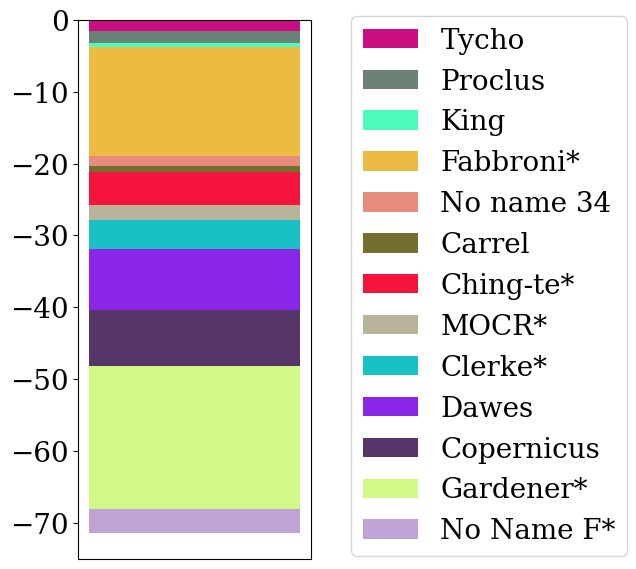

In [25]:
#Example of basic_model usage using Model 2 Ages Estimates

fig, ((ax1)) = plt.subplots(1,1,figsize=(3,7))
p1=basic_model(t_values_2,a_cont_ages_2,ax=ax1,color=colorlist,a_color=a_colorlist_17,cD=cD,aD=aD,cLon=cLon,cLat=cLat,aLon=aLon,aLat=aLat,cNames=cNames,aNames=(aNames),ra=105,a_ra=len(apollo),lon=30.76796,lat=20.18935)
handles, labels = ax1.get_legend_handles_labels()
lgd=fig.legend(handles, labels, loc='center right',bbox_to_anchor=((2,0.5)));

In [26]:
def mixing_model(age,a_age,color,a_color,ax,cD,aD,cLon,cLat,aLon,aLat,cNames,aNames,ra,a_ra,lon,lat):
    '''Mixing model of ejecta stratigraphy. 
    Best used to understand the potential contributing craters at a given location, 
    the amount they could potentially contribute, and the amount of vertical mixing over time.
    
    Assumes continuous ejecta at all distances and includes any craters contibuting more than 0.5 cm.
    Quantified the vertical mixing between layers with the overturn depth due to impact gardening [Costello et al., 2018]
    
    age = age of craters in Mazrouei database
    a_age = age of craters calculated using H-parameter of craters manually identified around apollo 17 site
    color, acolor = colors of the Mazroeui defined craters and manually identified craters (respectively)
    ax = axis for plot
    cD, aD = diameters of Mazroeui craters and manually identified craters (in km) (respectively)
    cLon, cLat = coordinates from Mazroeui craters
    aLon, aLat = coordinates from manually identitfied craters
    cNames, aNames = names of Mazroeui craters and manually identified craters (respectively)
    ra, a_ra = number of Mazroeui craters and manually identified craters (respectively)
    lon, lat = the location for the stratigraphy to predict
    '''
    
    #Sort the Mazrouei craters
    thickness=np.zeros(ra)
    distance=np.zeros(ra)
    distance_m=np.zeros(ra)
    sortD=cD[np.argsort(-age)]
    sortLon=cLon[np.argsort(-age)]
    sortLat=cLat[np.argsort(-age)]
    sortNames=cNames[np.argsort(-age)]
    sortAges=age[np.argsort(-age)]
        
    for i in range(ra):
        diameter=sortD[i]*1000 # into meters
        distance[i]=gCD(sortLon[i],sortLat[i],lon,lat)
        distance_m[i]=distance[i]*1000 # into meters
        thickness[i]=ejectaThickness(diameter,distance_m[i])
    
    thickness_cm=thickness*100 #into cm
    total=np.sum(thickness)
    percents=(thickness/total)*100

    names1=[]
    percents1=[]
    thickness1=[]
    thickness1_cm=[]
    age1=[]
    c_D=[]
    distance1=[]
        
    for i in range(ra):
        #only include crates that contribute 0.5 cm or more
        if thickness_cm[i]>=0.5:
            names1.append(sortNames[i])
            percents1.append(percents[i])
            thickness1.append(thickness[i])
            thickness1_cm.append(thickness_cm[i])
            age1.append(sortAges[i])
            c_D.append(sortD[i])
            distance1.append(distance[i])
            
    #Sort the manually identified craters
    a_thickness=np.zeros(a_ra)
    a_distance=np.zeros(a_ra)
    a_distance_m=np.zeros(a_ra)
    a_sortD=aD[np.argsort(-a_age)]
    a_sortLon=aLon[np.argsort(-a_age)]
    a_sortLat=aLat[np.argsort(-a_age)]
    a_sortNames=aNames[np.argsort(-a_age)]
    a_sortAges1=a_age[np.argsort(-a_age)]
    
    for i in range(a_ra):
        a_diameter=a_sortD[i]*1000 # into meters
        a_distance[i]=gCD(a_sortLon[i],a_sortLat[i],lon,lat) 
        a_distance_m[i]=a_distance[i]*1000# into meters
        a_thickness[i]=ejectaThickness(a_diameter,a_distance_m[i])
    
    a_thickness_cm=a_thickness*100 #into cm

    a_total=np.sum(a_thickness)
    a_percents=(a_thickness/a_total)*100

    a_names1=[]
    a_percents1=[]
    a_thickness1=[]
    a_thickness1_cm=[]
    a_age1=[]
    a_D=[]
    a_distance1=[]
        
    for i in range(a_ra):
        #only include crates that contribute 0.5 cm or more
        if a_thickness_cm[i]>=0.5:
            a_names1.append(a_sortNames[i])
            a_percents1.append(a_percents[i])
            a_thickness1.append(a_thickness[i])
            a_thickness1_cm.append(a_thickness_cm[i])
            a_age1.append(a_sortAges1[i])
            a_D.append(a_sortD[i])
            a_distance1.append(a_distance[i])
            
    #Combine the Mazrouei craters and the manually identified craters
    
    bottom=0
    final_names1=np.array(a_names1 + names1)
    final_percents1=np.array(a_percents1 + percents1)
    final_thickness1=np.array(a_thickness1 + thickness1)
    final_thickness1_cm=np.array(a_thickness1_cm + thickness1_cm)
    final_age1=np.array(a_age1 + age1)
    final_cD=np.array(a_D + c_D)
    final_distance=np.array(a_distance1 + distance1)
    
    final_Sortnames1=final_names1[np.argsort(-final_age1)]
    final_Sortpercents1=final_percents1[np.argsort(-final_age1)]
    final_Sortthickness1=final_thickness1[np.argsort(-final_age1)]
    final_Sortthickness1_cm=-final_thickness1_cm[np.argsort(-final_age1)]
    final_Sortage1=final_age1[np.argsort(-final_age1)]
    final_SortcD=final_cD[np.argsort(-final_age1)]
    final_Sortdistance=final_distance[np.argsort(-final_age1)]
        
    #Creating the basic model of the ejecta stratigraphy
    if ax==plt:
        plt.figure(figsize=(10,10))
    
    f_name=[]
    f_D=[]
    f_age=[]
    f_thick=[]
    f_distance=[]
    
    total_thickness = 0  
    total_thickness_list = []
    target_thickness = 150
    bottom=0
    
    final_color=color
    final_color.update(a_color)
    f_color=[]
    
    for j in reversed(range(len(final_Sortthickness1_cm))):
        if total_thickness < target_thickness:
            total_thickness_list.append(total_thickness)
            f_name.append(final_Sortnames1[j])
            f_D.append(final_SortcD[j])
            f_age.append(final_Sortage1[j])
            f_thick.append(final_Sortthickness1_cm[j])
            f_distance.append(final_Sortdistance[j])
            f_color.append(final_color[final_Sortnames1[j]])
            total_thickness += abs(final_Sortthickness1_cm[j])
            if final_Sortnames1[j] in aNames:
                ax.bar(0,final_Sortthickness1_cm[j],bottom=bottom,label=f'{final_Sortnames1[j]}*',color=final_color[final_Sortnames1[j]])
            else:
                ax.bar(0,final_Sortthickness1_cm[j],bottom=bottom,label=f'{final_Sortnames1[j]}',color=final_color[final_Sortnames1[j]])
            bottom=bottom+final_Sortthickness1_cm[j]
        else:
            break
        
    thickness_strat=abs(np.array(f_thick))
    layer_percentages=np.zeros((17,2))
    #Numerical model to calculate the overturn and vertical mixing over time
    for crater in range(len(f_name)):
        z_points=100

        timescale = 1000
        if crater==0:
            depth = ((2.52*(10**-6)) * ((0.5*1000000)**0.61))*100 #cm
        else:
            if f_age[crater-1]>4000:
                depth = ((2.52*(10**-6)) * ((1000*1000000)**0.61))*100 #cm
            else:
                depth = ((2.52*(10**-6)) * ((f_age[crater-1]*1000000)**0.61))*100 #cm
        D = depth**2/timescale #cm^2/Myr

        if crater==0:
            top_layer=1
        else:
            top_layer=(thickness_strat[crater-1]/2)


        if crater==(ra-1):
            bottom_layer=10
        else:
            bottom_layer=(thickness_strat[crater]/2)

        delta_z = (top_layer+bottom_layer)/z_points

        index=int(top_layer / delta_z)
        if index==0:
            z_points=2000
            delta_z=(top_layer+bottom_layer)/(z_points)

        if index==99:
            z_points=2000
            delta_z=(top_layer+bottom_layer)/(z_points)
        
        delta_t = (delta_z**2) / (2 * D)
        time_steps = 3001 #0.33 (1/3) Myr per timestep

        initial_conc = np.zeros(z_points)
        initial_conc[:int(top_layer / delta_z)] = 1.0

        current_conc = np.copy(initial_conc)
        next_conc = np.zeros_like(current_conc)

        for t in range(time_steps):
            for i in range(1, z_points - 1):
                delta_c=current_conc[i-1]-2*current_conc[i]+current_conc[i+1]
                next_conc[i]=current_conc[i] + D * delta_c * delta_t/(delta_z**2)

            next_conc[0] = next_conc[1]
            next_conc[-1] = next_conc[-2]

            current_conc, next_conc = next_conc, current_conc

            if f_age[crater]<4000:
                if t==(int(f_age[crater])*3):
                    index=int(top_layer / delta_z)
                    percent_top_layer = (np.sum(next_conc[:index])/index)*100
                    percent_bottom_layer = (np.sum((1-next_conc[index+1:]))/(100-(index+1)))*100
                    layer_percentages[crater]=[percent_top_layer,percent_bottom_layer]
            else:
                if t==(int(1000)*3):
                    index=int(top_layer / delta_z)
                    percent_top_layer = (np.sum(next_conc[:index])/index)*100
                    percent_bottom_layer = (np.sum((1-next_conc[index+1:]))/(100-(index+1)))*100
                    layer_percentages[crater]=[percent_top_layer,percent_bottom_layer]
                    
    #including the mixing model into the visual representation of the basic model
    for crater in range(len(f_name)):
        pre_layer=((100-layer_percentages[crater,1])/2)/100
        post_layer=((100-layer_percentages[crater+1,0])/2)/100

        layer0=-total_thickness_list[crater]

        layer1=-total_thickness_list[crater]-thickness_strat[crater]

        thick1=-thickness_strat[crater]

        x = np.arange(-0.4,0.5,0.1)

        if crater==0:
            ax.fill_betweenx(np.arange((layer0+(thick1/2)*pre_layer),layer0+0.01,0.01), -0.4, 0.4, color='black', hatch='/', alpha=0.3)
        else:
            ax.fill_betweenx(np.arange((layer0+(thick1/2)*pre_layer),layer0+0.01,0.01), -0.4, 0.4, color=f_color[crater-1], hatch='/', alpha=0.3)
        
        if crater==(len(f_name)-1):
            ax.fill_betweenx(np.arange(layer1,(layer1-((thick1/2)*post_layer))+0.01, 0.01), -0.4, 0.4, color='white', hatch='\\', alpha=0.3)
        else:
            ax.fill_betweenx(np.arange(layer1,(layer1-((thick1/2)*post_layer))+0.01, 0.01), -0.4, 0.4, color=f_color[crater+1], hatch='\\', alpha=0.3)

    if ax==plt:
        plt.ylabel("Ejecta Stratigraphy (cm)")
        plt.tick_params(labelbottom = False, bottom = False)
        plt.show() 
    else:
        #ax.set_xlabel("Depth (cm)")
        ax.tick_params(labelbottom = False, bottom = False)
    
    #Produces a visual representation and lists of craters names (f_name), crater diameters (f_D), 
    #crater ages (f_age), individual crater contributions (abs(np.array(f_thick)), 
    #distances from sample site (f_distance), total ejecta thickness (total_thickness_list)
    return f_name, f_D, f_age, abs(np.array(f_thick)), f_distance, total_thickness_list

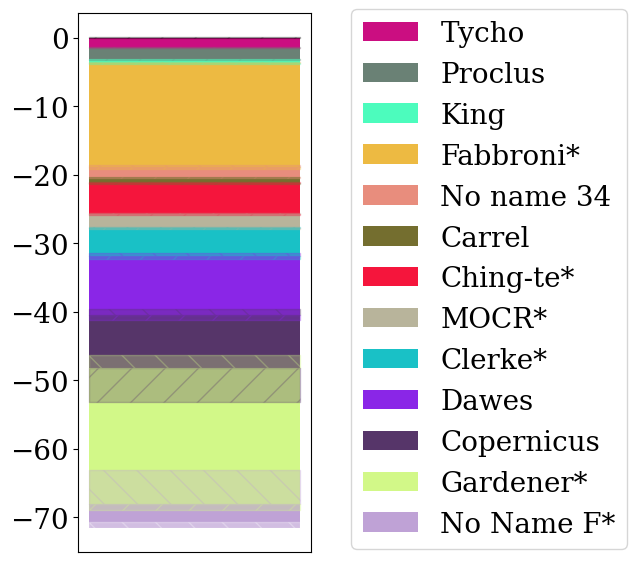

In [27]:
#Example of mixing_model usage using Model 2 Ages Estimates

fig, ((ax1)) = plt.subplots(1,1,figsize=(3,7))
p2=mixing_model(t_values_2,a_cont_ages_2,ax=ax1,color=colorlist,a_color=a_colorlist_17,cD=cD,aD=aD,cLon=cLon,cLat=cLat,aLon=aLon,aLat=aLat,cNames=cNames,aNames=aNames,ra=105,a_ra=len(apollo),lon=30.76796,lat=20.18935)
handles, labels = ax1.get_legend_handles_labels()
lgd=fig.legend(handles, labels, loc='center right',bbox_to_anchor=((2,0.5)));

In [28]:
def ray_model(age,a_age,color,a_color,ax,cD,aD,cLon,cLat,aLon,aLat,cNames,aNames,ra,a_ra,lon,lat):
    '''Ray model of ejecta stratigraphy. 
    Best used to understand the effects of crater rays at a given location, 
    the amount of potentially contributing ejecta from contributing crater,
    and the amount of vertical mixing over time.
    
    Assumes discontinuous ejecta after 3 crater radii and includes any craters contibuting more than 0.5 cm.
    Quantified the vertical mixing between layers with the overturn depth due to impact gardening [Costello et al., 2018]
    Provides the stratigraphy that includes the physical processes at play.
    
    age = age of craters in Mazrouei database
    a_age = age of craters calculated using H-parameter of craters manually identified around apollo 17 site
    color, acolor = colors of the Mazroeui defined craters and manually identified craters (respectively)
    ax = axis for plot
    cD, aD = diameters of Mazroeui craters and manually identified craters (in km) (respectively)
    cLon, cLat = coordinates from Mazroeui craters
    aLon, aLat = coordinates from manually identitfied craters
    cNames, aNames = names of Mazroeui craters and manually identified craters (respectively)
    ra, a_ra = number of Mazroeui craters and manually identified craters (respectively)
    lon, lat = the location for the stratigraphy to predict
    '''
    
    #Sort the Mazrouei craters
    thickness=np.zeros(ra)
    distance=np.zeros(ra)
    distance_m=np.zeros(ra)
    sortD=cD[np.argsort(-age)]
    sortLon=cLon[np.argsort(-age)]
    sortLat=cLat[np.argsort(-age)]
    sortNames=cNames[np.argsort(-age)]
    sortAges=age[np.argsort(-age)]
    
    for i in range(ra):
        diameter=sortD[i]*1000 # into meters
        distance[i]=gCD(sortLon[i],sortLat[i],lon,lat)
        distance_m[i]=distance[i]*1000 # into meters
        thickness[i]=ejectaThickness(diameter,distance_m[i])
    
    thickness_cm=thickness*100 #into cm
    total=np.sum(thickness)
    percents=(thickness/total)*100

    names1=[]
    percents1=[]
    thickness1=[]
    thickness1_cm=[]
    age1=[]
    c_D=[]
    distance1=[]

    for i in range(ra):
        #only include crates that contribute 0.5 cm or more
        if thickness_cm[i]>=0.5:
            names1.append(sortNames[i])
            percents1.append(percents[i])
            thickness1.append(thickness[i])
            thickness1_cm.append(thickness_cm[i])
            age1.append(sortAges[i])
            c_D.append(sortD[i])
            distance1.append(distance[i])
            
    #Sort the manually identified craters
    a_thickness=np.zeros(a_ra)
    a_distance=np.zeros(a_ra)
    a_distance_m=np.zeros(a_ra)
    a_sortD=aD[np.argsort(-a_age)]
    a_sortLon=aLon[np.argsort(-a_age)]
    a_sortLat=aLat[np.argsort(-a_age)]
    a_sortNames=aNames[np.argsort(-a_age)]
    a_sortAges1=a_age[np.argsort(-a_age)]
    
    for i in range(a_ra):
        a_diameter=a_sortD[i]*1000 # into meters
        a_distance[i]=gCD(a_sortLon[i],a_sortLat[i],lon,lat) 
        a_distance_m[i]=a_distance[i]*1000# into meters
        a_thickness[i]=ejectaThickness(a_diameter,a_distance_m[i])
    
    a_thickness_cm=a_thickness*100 #into cm

    a_total=np.sum(a_thickness)
    a_percents=(a_thickness/a_total)*100

    a_names1=[]
    a_percents1=[]
    a_thickness1=[]
    a_thickness1_cm=[]
    a_age1=[]
    a_D=[]
    a_distance1=[]
        
    for i in range(a_ra):
        #only include crates that contribute 0.5 cm or more
        if a_thickness_cm[i]>=0.5:
            a_names1.append(a_sortNames[i])
            a_percents1.append(a_percents[i])
            a_thickness1.append(a_thickness[i])
            a_thickness1_cm.append(a_thickness_cm[i])
            a_age1.append(a_sortAges1[i])
            a_D.append(a_sortD[i])
            a_distance1.append(a_distance[i])
            
    #Combine the Mazrouei craters and the manually identified craters
    bottom=0
    final_names1=np.array(a_names1 + names1)
    final_percents1=np.array(a_percents1 + percents1)
    final_thickness1=np.array(a_thickness1 + thickness1)
    final_thickness1_cm=np.array(a_thickness1_cm + thickness1_cm)
    final_age1=np.array(a_age1 + age1)
    final_cD=np.array(a_D + c_D)
    final_distance=np.array(a_distance1 + distance1)
    
    final_Sortnames1=final_names1[np.argsort(-final_age1)]
    final_Sortpercents1=final_percents1[np.argsort(-final_age1)]
    final_Sortthickness1=final_thickness1[np.argsort(-final_age1)]
    final_Sortthickness1_cm=-final_thickness1_cm[np.argsort(-final_age1)]
    final_Sortage1=final_age1[np.argsort(-final_age1)]
    final_SortcD=final_cD[np.argsort(-final_age1)]
    final_Sortdistance=final_distance[np.argsort(-final_age1)]
        
    #Creating the basic model of the ejecta stratigraphy
    if ax==plt:
        plt.figure(figsize=(10,10))
    
    f_name=[]
    f_D=[]
    f_age=[]
    f_thick=[]
    f_distance=[]
    f_rays=[]
    
    total_thickness = 0  
    total_thickness_list = []
    target_thickness = 100000
    bottom=0
    
    final_color=color
    final_color.update(a_color)
    f_color=[]
    
    for j in reversed(range(len(final_Sortthickness1_cm))):
        cr=final_Sortdistance[j]/(final_SortcD[j]/2)
        cr_random=random.random()
        # If the crater distance is greater than a random number from 0 to 1, the crater is included as a ray
        # 3/cr ensures that all craters closer than 3 crater radii from the sample site are always included
        if (3 / (cr)) > cr_random:   
            #the thickness is 39.8 times greater in the rays due to shape models of crater rays from Huang et al., 2017 
            thickness_plot=final_Sortthickness1_cm[j]*39.81583689356834
        
            total_thickness_list.append(total_thickness)
            f_D.append(final_SortcD[j])
            f_age.append(final_Sortage1[j])
            f_thick.append(thickness_plot)
            f_distance.append(final_Sortdistance[j])
            f_color.append(final_color[final_Sortnames1[j]])
            f_rays.append(10.5*((final_SortcD[j]/2)**1.25))
            total_thickness += abs(thickness_plot)
            if final_Sortnames1[j] in aNames:
                ax.bar(0,thickness_plot,bottom=bottom,label=f'{final_Sortnames1[j]}*',color=final_color[final_Sortnames1[j]])
                f_name.append(f'{final_Sortnames1[j]}*')
            else:
                ax.bar(0,thickness_plot,bottom=bottom,label=f'{final_Sortnames1[j]}',color=final_color[final_Sortnames1[j]])
                f_name.append(f'{final_Sortnames1[j]}')
            bottom=bottom+thickness_plot
        else:
            pass
    
    thickness_strat=abs(np.array(f_thick))
    layer_percentages=np.zeros((17,2))
    #Numerical model to calculate the overturn and vertical mixing over time
    for crater in range(len(f_name)):
        z_points=100

        timescale = 1000
        if crater==0:
            depth = ((2.52*(10**-6)) * ((0.5*1000000)**0.61))*100 #cm
        else:
            if f_age[crater-1]>4000:
                depth = ((2.52*(10**-6)) * ((1000*1000000)**0.61))*100 #cm
            else:
                depth = ((2.52*(10**-6)) * ((f_age[crater-1]*1000000)**0.61))*100 #cm
        D = depth**2/timescale #cm^2/Myr

        if crater==0:
            top_layer=1
        else:
            top_layer=(thickness_strat[crater-1]/2)


        if crater==(ra-1):
            bottom_layer=10
        else:
            bottom_layer=(thickness_strat[crater]/2)

        delta_z = (top_layer+bottom_layer)/z_points

        index=int(top_layer / delta_z)
        if index==0:
            z_points=2000
            delta_z=(top_layer+bottom_layer)/(z_points)

        if index==99:
            z_points=2000
            delta_z=(top_layer+bottom_layer)/(z_points)
        
        delta_t = (delta_z**2) / (2 * D)
        time_steps = 3001 #0.33 (1/3) Myr per timestep

        initial_conc = np.zeros(z_points)
        initial_conc[:int(top_layer / delta_z)] = 1.0

        current_conc = np.copy(initial_conc)
        next_conc = np.zeros_like(current_conc)

        for t in range(time_steps):
            for i in range(1, z_points - 1):
                delta_c=current_conc[i-1]-2*current_conc[i]+current_conc[i+1]
                next_conc[i]=current_conc[i] + D * delta_c * delta_t/(delta_z**2)

            next_conc[0] = next_conc[1]
            next_conc[-1] = next_conc[-2]

            current_conc, next_conc = next_conc, current_conc

            if f_age[crater]<4000:
                if t==(int(f_age[crater])*3):
                    index=int(top_layer / delta_z)
                    percent_top_layer = (np.sum(next_conc[:index])/index)*100
                    percent_bottom_layer = (np.sum((1-next_conc[index+1:]))/(100-(index+1)))*100
                    layer_percentages[crater]=[percent_top_layer,percent_bottom_layer]
            else:
                if t==(int(1000)*3):
                    index=int(top_layer / delta_z)
                    percent_top_layer = (np.sum(next_conc[:index])/index)*100
                    percent_bottom_layer = (np.sum((1-next_conc[index+1:]))/(100-(index+1)))*100
                    layer_percentages[crater]=[percent_top_layer,percent_bottom_layer]
                    
    #including the mixing model into the visual representation of the basic model
    for crater in range(len(f_name)):
        pre_layer=((100-layer_percentages[crater,1])/2)/100
        post_layer=((100-layer_percentages[crater+1,0])/2)/100

        layer0=-total_thickness_list[crater]

        layer1=-total_thickness_list[crater]-thickness_strat[crater]

        thick1=-thickness_strat[crater]

        x = np.arange(-0.4,0.5,0.1)

        if crater==0:
            ax.fill_betweenx(np.arange((layer0+(thick1/2)*pre_layer),layer0+0.01,0.01), -0.4, 0.4, color='black', hatch='/', alpha=0.3)
        else:
            ax.fill_betweenx(np.arange((layer0+(thick1/2)*pre_layer),layer0+0.01,0.01), -0.4, 0.4, color=f_color[crater-1], hatch='/', alpha=0.3)
        
        if crater==(len(f_name)-1):
            ax.fill_betweenx(np.arange(layer1,(layer1-((thick1/2)*post_layer))+0.01, 0.01), -0.4, 0.4, color='white', hatch='\\', alpha=0.3)
        else:
            ax.fill_betweenx(np.arange(layer1,(layer1-((thick1/2)*post_layer))+0.01, 0.01), -0.4, 0.4, color=f_color[crater+1], hatch='\\', alpha=0.3)
    
    if ax==plt:
        plt.ylabel("Ejecta Stratigraphy (cm)")
        plt.tick_params(labelbottom = False, bottom = False)
        plt.show() 
    else:
        #ax.set_xlabel("Depth (cm)")
        ax.tick_params(labelbottom = False, bottom = False)
        
    #Produces a visual representation and lists of craters names (f_name), distances from sample site (f_distance),
    #maximum length of crater rays (f_rays), individual crater contributions (f_thick), 
    #total ejecta thickness (total_thickness_list)
    return f_name,f_distance,f_rays,f_thick,total_thickness

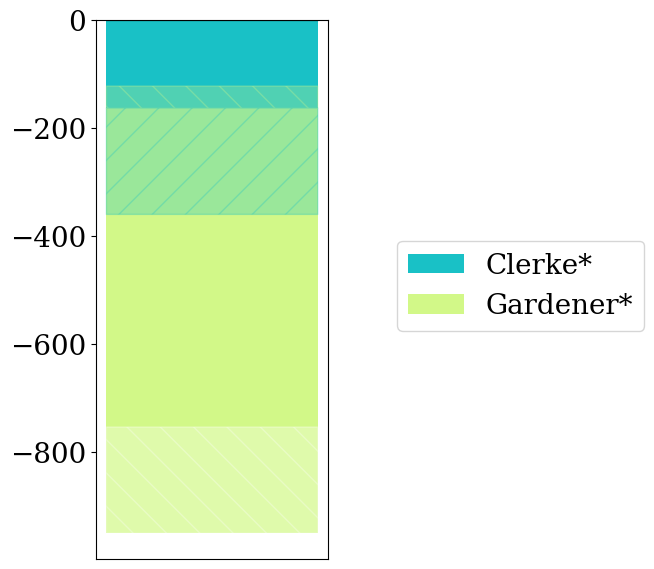

In [29]:
#Example of ray_model usage using Model 2 Ages Estimates

fig, ((ax1)) = plt.subplots(1,1,figsize=(3,7))
p3=ray_model(t_values_2,a_cont_ages_2,ax=ax1,color=colorlist,a_color=a_colorlist_17,cD=cD,aD=aD,cLon=cLon,cLat=cLat,aLon=aLon,aLat=aLat,cNames=cNames,aNames=aNames,ra=105,a_ra=len(apollo),lon=30.76796,lat=20.18935)
handles, labels = ax1.get_legend_handles_labels()
lgd=fig.legend(handles, labels, loc='center right',bbox_to_anchor=((2,0.5)));

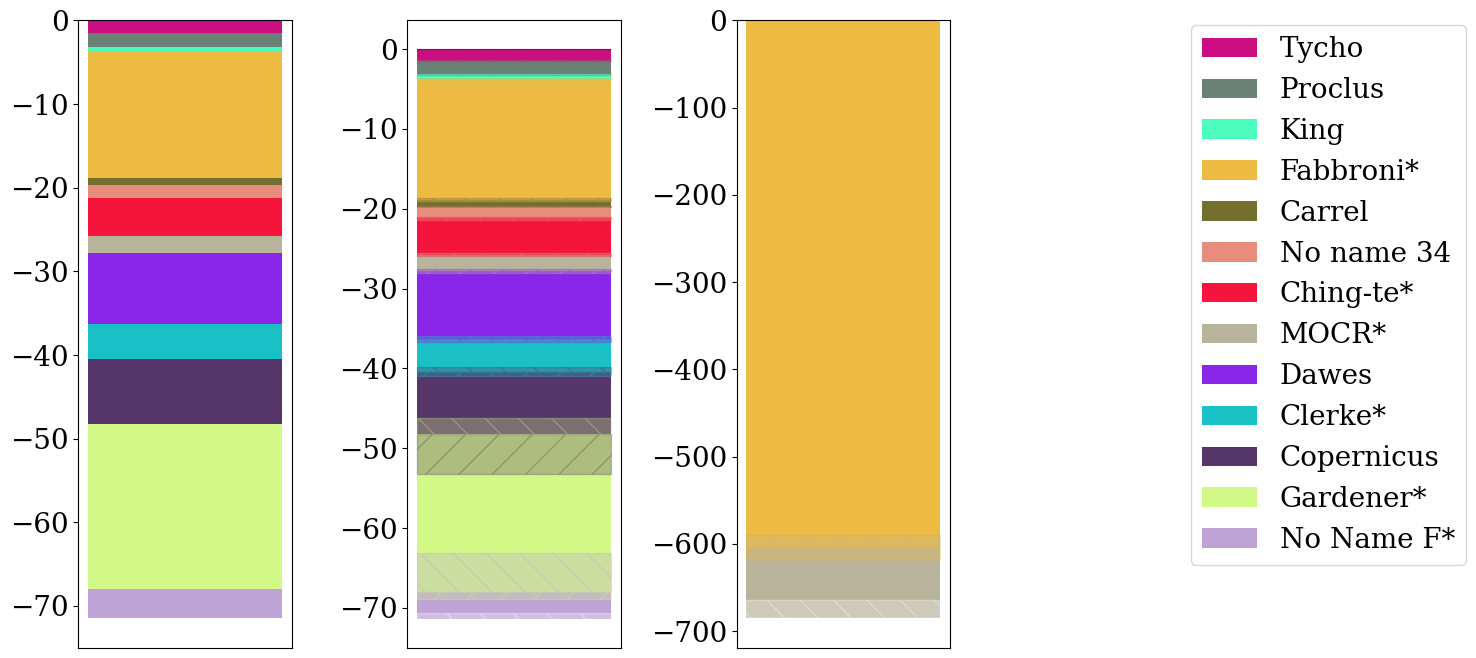

In [30]:
#Example of all models

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,7))

all_c,all_d,all_t,all_s,all_dis,all_tot,all_h1,all_h2=basic_model(t_values_1,a_cont_ages_2,ax=ax1,color=colorlist,a_color=a_colorlist_17,cD=cD,aD=aD,cLon=cLon,cLat=cLat,aLon=aLon,aLat=aLat,cNames=cNames,aNames=(aNames),ra=105,a_ra=len(apollo),lon=30.76796,lat=20.18935)
mix_c,mix_d,mix_t,mix_s,mix_dis,mix_tot=mixing_model(t_values_1,a_cont_ages_2,ax=ax2,color=colorlist,a_color=a_colorlist_17,cD=cD,aD=aD,cLon=cLon,cLat=cLat,aLon=aLon,aLat=aLat,cNames=cNames,aNames=aNames,ra=105,a_ra=len(apollo),lon=30.76796,lat=20.18935)
rayc,ray_d,rayss,rays_s,ray_tot=ray_model(t_values_1,a_cont_ages_2,ax=ax3,color=colorlist,a_color=a_colorlist_17,cD=cD,aD=aD,cLon=cLon,cLat=cLat,aLon=aLon,aLat=aLat,cNames=cNames,aNames=(aNames),ra=105,a_ra=len(apollo),lon=30.76796,lat=20.18935)

plt.tight_layout()
all_handles, all_labels = ax1.get_legend_handles_labels()
all_lgd=fig.legend(all_handles, all_labels, loc='center right',bbox_to_anchor=((1.5,0.55)));